# Применение решающих деревьев на наборе данных Титаник. Кросс-валидация

Считаем данные, датасет "Титаник"

In [1]:
import pandas as pd

titanic_data = pd.read_csv('./data/titanic/train.csv')
titanic_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Задача: обучить дерево решений, на предсказание выживаемости пассажира.

### Преподготовка
Проверим данные на пустоту

In [2]:
titanic_data.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Отбросим поля PassengerId, Cabin, Ticket, Name, а так же поле, которое будем предсказывать - Survived.

In [3]:
X = titanic_data.drop(['PassengerId', 'Cabin', 'Ticket', 'Name', 'Survived'], axis=1)
X.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,22.0,1,0,7.2500,S
1,1,female,38.0,1,0,71.2833,C
2,3,female,26.0,0,0,7.9250,S
3,1,female,35.0,1,0,53.1000,S
4,3,male,35.0,0,0,8.0500,S


Трансформируем строковые значения в числовые

In [4]:
X = pd.get_dummies(X)
X.head()

,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,3,22.0,1,0,7.2500,0,1,0,0,1
1,1,38.0,1,0,71.2833,1,0,1,0,0
2,3,26.0,0,0,7.9250,1,0,0,0,1
3,1,35.0,1,0,53.1000,1,0,0,0,1
4,3,35.0,0,0,8.0500,0,1,0,0,1


Заполним пропущенные значения возраста

In [5]:
X = X.fillna({'Age': X.Age.median()})

In [6]:
y = titanic_data.Survived

Сохраним переработанные исходные данные для последующего использования

In [7]:
X.to_pickle('./data/titanic/train_x.pkl')
y.to_pickle('./data/titanic/train_y.pkl')

Создадим модель дерева решений

In [8]:
import sklearn.tree as tree

clf = tree.DecisionTreeClassifier(criterion='entropy')
clf.fit(X, y)

DecisionTreeClassifier(criterion='entropy')

Выведем дерево решений

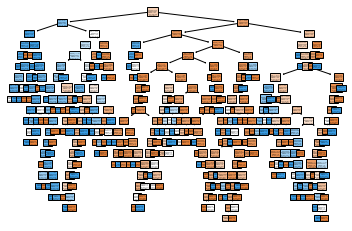

In [9]:
tree.plot_tree(clf, feature_names=list(X),
               class_names=['Died', 'Survived'],
               filled=True);

Результирующее дерево решений имеет сложную структуру. Явно выражено переобучение (overfitting).  
Решение - ограничить глубину дерева.

Разобъем данные на тренировочный и проверочный сеты

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

Убедимся в том, что в модели есть проблема переобучения

In [11]:
clf.score(X, y)

0.9797979797979798

In [12]:
clf.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy')

Посмотрим точность классификации на обучающем множестве

In [13]:
clf.score(X_train, y_train)

0.9798657718120806

Посмотрим точность на тестовом множестве

In [14]:
clf.score(X_test, y_test)

0.7728813559322034

Видим значительную разницу в оценке.
Попробуем ограничить глубину дерева

In [15]:
clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=4)
clf.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=4)

Проверим точность на тренировочных и тестовых данных

In [16]:
clf.score(X_train, y_train)

0.8338926174496645

In [17]:
clf.score(X_test, y_test)

0.823728813559322

Найдём оптимальную глубину дерева, ручным перебором параметра max_depth

In [18]:
max_depth_values = range(1, 30)

scores_data = pd.DataFrame()

for max_depth in max_depth_values:
    clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=max_depth)
    clf.fit(X_train, y_train)

    train_score = clf.score(X_train, y_train)
    test_score = clf.score(X_test, y_test)

    scores_data = scores_data.append(pd.DataFrame({'max_depth': [max_depth], 'train_score': train_score, 'test_score': test_score}))

In [19]:
scores_data.head()

,max_depth,train_score,test_score
0,1,0.781879,0.796610
0,2,0.805369,0.776271
0,3,0.823826,0.820339
0,4,0.833893,0.823729
0,5,0.840604,0.806780


Преобразум данные для визуализации

In [20]:
scores_data_long = pd.melt(scores_data, id_vars=['max_depth'], value_vars=['train_score', 'test_score'], var_name='set_type', value_name='score')
scores_data_long.head()

,max_depth,set_type,score
0,1,train_score,0.781879
1,2,train_score,0.805369
2,3,train_score,0.823826
3,4,train_score,0.833893
4,5,train_score,0.840604


Постоим графики зависимости глубины дерева и оценки качества

<AxesSubplot:xlabel='max_depth', ylabel='score'>

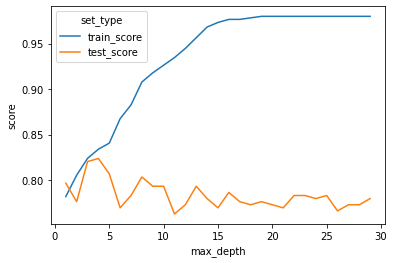

In [21]:
import seaborn as sns

sns.lineplot(x='max_depth', y='score', hue='set_type', data=scores_data_long)

Тоже самое? методом без преобразований (средствами pandas)

<AxesSubplot:xlabel='max_depth'>

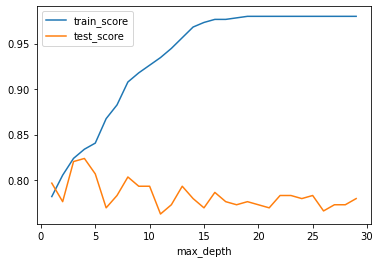

In [22]:
scores_data.plot(x='max_depth', y=['train_score', 'test_score'])

Интерпретация: на графике видно, что при глубине дерева до 4 модель не обучилась (точность предсказаний на тестовой выборке не достигла пика),  
а дальше происходит переобучение (модель начинает хорошо предсказывать тренировочный набору и плохо тестовый).

Подбирая параметры модели (глубину дерева) для заданной тестовой выборки мы не избавляемся от переобучения.  
Один из способов решения проблемы - деление исходных данных на тренировочную выборку, валидационную выборку и финальную проверочную (которую не видела модель).

# Кросс-валидация (перекрестная проверка)

Тренеровочный набор данных делим на n(часто 5) одинаковых частей.  
Берём первый набор, обучаем модель на 2-n наборах и тестируем на первом.  
Далее обучаем на 1, 3-n и проверяем на втором.  
Потом обучаем на 1-2, 4-n и тестируем на 3-ем ..   
Т.о. каждый фрагмент данных побывает и в обучении и в валидации.  
Далее мы можем усреднить точность классификации.

In [23]:
clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=4)

Рассчитаем среднюю точность на кроссвалидации:

In [24]:
from sklearn.model_selection import cross_val_score

cross_val_score(clf, X_train, y_train, cv=5).mean()

0.7886274509803922

Снова проверим модель, используя разную глубину дерева. Сохраним среднюю оценку кросс валидации

In [25]:
max_depth_values = range(1, 30)

scores_data = pd.DataFrame()

for max_depth in max_depth_values:
    clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=max_depth)
    clf.fit(X_train, y_train)

    train_score = clf.score(X_train, y_train)
    test_score = clf.score(X_test, y_test)

    mean_score_val_score = cross_val_score(clf, X_train, y_train, cv=5).mean()

    scores_data = scores_data.append(pd.DataFrame({'max_depth': [max_depth], 'train_score': train_score, 'test_score': test_score, 'cross_val_score': mean_score_val_score}))

<AxesSubplot:xlabel='max_depth'>

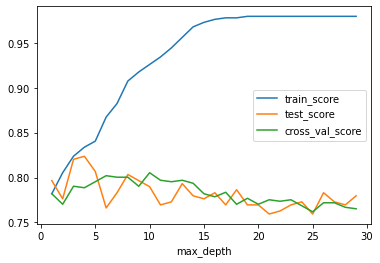

In [26]:
scores_data.plot(x='max_depth', y=['train_score', 'test_score', 'cross_val_score'])

Максимальная точность на кросс валидации достигается уже при большей глубине дерева

### Задание
Скачайте тренировочный датасэт с ирисами, обучите деревья с глубиной от 1 до 100.  
Целевой переменной при обучении является переменная species. При этом записывайте его скор (DecisionTreeClassifier.score()) на тренировочных данных,  
и аккуратность предсказаний (accuracy_score) на тестовом датасэте. Затем визуализируйте зависимость скора и аккуратности предсказаний от глубины дерева.

Важно: задайте random seed прямо перед созданием дерева или укажите его в параметрах дерева (random_state=rs)

np.random.seed(0)
my_awesome_tree = DecisionTreeClassifier(...)
или

my_awesome_tree = DecisionTreeClassifier(random_state=0, ...)

In [27]:
iris_train_data = pd.read_csv('https://stepik.org/media/attachments/course/4852/train_iris.csv', index_col=0)
iris_test_data = pd.read_csv('https://stepik.org/media/attachments/course/4852/test_iris.csv', index_col=0)

In [28]:
X_train = iris_train_data.drop(['species'], axis=1)
y_train = iris_train_data.species

X_test = iris_test_data.drop(['species'], axis=1)
y_test = iris_test_data.species

<AxesSubplot:xlabel='max_depth'>

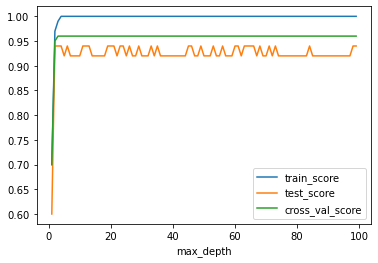

In [29]:
import numpy as np

rs = np.random.seed(0)

max_depth_values = range(1, 100)

scores_data = pd.DataFrame()

for max_depth in max_depth_values:
    clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=max_depth, random_state=rs)
    clf.fit(X_train, y_train)

    train_score = clf.score(X_train, y_train)
    test_score = clf.score(X_test, y_test)

    mean_score_val_score = cross_val_score(clf, X_train, y_train, cv=5).mean()

    scores_data = scores_data.append(pd.DataFrame({'max_depth': [max_depth], 'train_score': train_score, 'test_score': test_score, 'cross_val_score': mean_score_val_score}))

scores_data.plot(x='max_depth', y=['train_score', 'test_score', 'cross_val_score'])

### Задание
Мы собрали побольше данных о котиках и собачках, и готовы обучить нашего робота их классифицировать!  
Скачайте тренировочный датасэт и обучите на нём Decision Tree.  
После этого скачайте датасэт из задания и предскажите какие наблюдения к кому относятся.

In [30]:
dogs_and_cats_data = pd.read_csv('https://stepik.org/media/attachments/course/4852/dogs_n_cats.csv')
dogs_and_cats_data.head()

,Длина,Высота,Шерстист,Гавкает,Лазает по деревьям,Вид
0,15,18.0,1,1,0,собачка
1,20,24.0,1,0,0,собачка
2,34,40.8,1,1,0,собачка
3,26,31.2,1,1,0,собачка
4,16,19.2,1,1,0,собачка


In [31]:
X_train = dogs_and_cats_data.drop(['Вид'], axis=1)
X_train.head()

,Длина,Высота,Шерстист,Гавкает,Лазает по деревьям
0,15,18.0,1,1,0
1,20,24.0,1,0,0
2,34,40.8,1,1,0
3,26,31.2,1,1,0
4,16,19.2,1,1,0


In [32]:
y_train = pd.get_dummies(dogs_and_cats_data.Вид)
y_train = y_train.drop(['котик'], axis=1)
y_train.head()

,собачка
0,1
1,1
2,1
3,1
4,1


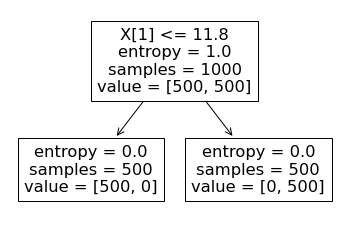

In [33]:
clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=3)
clf.fit(X_train, y_train)

tree.plot_tree(clf);

In [34]:
X_test = pd.read_json('./data/dataset_209691_15.txt')
y_pred = clf.predict(X_test)

print(y_pred)

print('Собачек:', y_pred.tolist().count(1))
print('Котиков:', y_pred.tolist().count(0))

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Собачек: 47
Котиков: 53
